**Changes** - The data directories should be located directly in the data folder, not in subfolders by month. The load_data() function takes in the path to the data directory and the language to filter by (None returns all languages). It returns the data from the directories as a dataframe. I also added some additional data fields from the XML files to the dataframe.

Added a function to get download files from the TED FTP site.

Added a function to recursively unpack XML files, it loops through the items in the dictionary, if the item is a string it adds it, if it is another dictionary it recurses through the dictionary, appending the keys to avoid overwriting previous values. Doing this results in a huge number of columns, of which only 200 or so are not null in more than 95% of the rows.

In block 58 we can see the different document types. I think that all other than the top 2 or 3 can safely be ignored as they seem exceedingly rare.

I also created text files with the columns for each of four types of notices:
 * Additional Information
 * Contract notices
 * Contract award notices
 * Concession award notices
 
It seems that the different document types have significantly different columns, enough that it may make sense to use separate tables or databases for them.

** Change Log**
 * 2019-02-24 - Ignoring "FT" tags in XML - these mean font and usually are used to indicate a number and can safely be removed. Also changed handling of "P" tags - these are paragraphs and should be appended to the parent tag rather than made into their own columns. Exception is when the P contains an ordereddict which does NOT contain "#text" as a key. This has greatly reduced the number of useless columns in the dataframe.
 * 2019-02-26 - Instead of creating strings where there are multiple instances of the same key in the XML we create a list of the values. This will make it easier to correlate the values in the cases where this needs to be done, such as where there are multiple objects being requested.

**To Do**:
 * Try to filter out translations so we only get the translation for the proper language if it is somewhere in the forms.

In [84]:
import json
import os
import collections
import io
import numpy as np
import xmltodict
import wget
import pandas as pd
import json
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer

In [142]:
USE_COLS = list(np.load("columns.npy"))

* [TED Schemas](https://publications.europa.eu/en/web/eu-vocabularies/tedschemashttps://publications.europa.eu/en/web/eu-vocabularies/tedschemas)
* [Forms in PDF ](http://simap.ted.europa.eu/standard-forms-for-public-procurement)
* [Daily Notices](https://data.europa.eu/euodp/data/dataset/ted-1/resource/0eec3f91-27f1-4ce0-91d2-102d82cb97ec)
* [Stop words in different languages](https://github.com/stopwords-iso)

In [85]:
from ftplib import FTP
import datetime
import os
import tarfile
import wget

# Function download_files:
# FTPs to ftp_path, gets list of files in the directory for the current year and month (note that this may cause
# problems on the first day of the month downloading the files from the last day of the previous month); makes a list 
# of files to be download. Then downloads the files with wget (ftp was not downloading the entire file); unzips the 
# tarballs and then deletes the tar.gz file.
# 
# Params:
# - data_path -> path to download data to
# - ftp_path -> URI for FTP
# - username, password -> username and password for FTP login
# - year, month -> year and month to download data for, if None will use current month and year
# - max_files -> max number of files to download, useful for debuggin
# - delete_files -> whether to delete the files that have been successfully extracted
#
# Returns:
# - list of files downloaded and successfully extracted
#
# Note that sometimes using the URL throws an error, in this case use the IP address: 91.250.107.123

def download_files(data_path="data", ftp_path="ted.europa.edu", username="guest", password="guest", year=None, month=None, max_files=None, delete_files=True):
    ## USE FTP TO GET THE LIST OF FILES TO DOWNLOAD
    with FTP(ftp_path, user=username, passwd=password) as ftp:
        # create the directory name for the current month and year
        # we may want to do this for yesterday 
        now = datetime.datetime.now()
        if year is None:
            year = str(now.year)
        if month is None:
            month = datetime.datetime.now().strftime('%m')

        # go to that directory and get the files in it
        ftp.cwd('daily-packages/' + year + "/" + month) 
        dir_list = ftp.nlst() 
        files_to_download = []

        # loop through the files
        for file in dir_list:
            file_name = file.split(".")[0]
            end = file_name.split("_")
            end[1] = end[1][4:]
            dir_name = "_".join(end)

            # if the directory does not exist we should download the file
            if not os.path.exists(os.path.join(data_path, dir_name)):
                # download the file with wget since ftplib seems to only download a small part of the file
                file_path = "ftp://"+username+":"+password+"@" + ftp_path + "/daily-packages/" + year + "/" + month + "/" + file
                files_to_download.append(file_path)

    # download the files with wget so we can download the entire file without errors            
    downloaded_files = []
    for i, file in enumerate(files_to_download):
        try:
            print("Downloading", file)
            d_file = wget.download(file, data_path)
            downloaded_files.append(d_file)
        except:
            print("Error downloading", file)
        
        if max_files is not None and i >= max_files:
            break
    
    extracted_files = []
    # extract the tarballs
    for file in downloaded_files:
        print("\nExtracting:", file)
        try:
            if (file.endswith("tar.gz")):
                tar = tarfile.open(file, "r:gz")
                tar.extractall(data_path)
                tar.close()
            elif (file.endswith("tar")):
                tar = tarfile.open(file, "r:")
                tar.extractall()
                tar.close()
            
            extracted_files.append(file)
            if delete_files:
                # if everything was properly extracted we can delete the file
                os.remove(file)
            
        except:
            print("Error extracting", file)
            
    return extracted_files

In [86]:
def flatten_xml_dicts(xml_dict, results_dict):
    for key in xml_dict.keys():
        if isinstance(xml_dict[key], collections.OrderedDict):
            for key2 in xml_dict[key]:
                if "text" in key2:
                    results_dict[key] = xml_dict[key][key2]
                elif "CODE" in key2:
                    results_dict[key + "_CODE"] = xml_dict[key][key2]
        elif isinstance(xml_dict[key], list):
            results_dict[key] = []
            results_dict[key + "_CODE"] = []
            for list_item in xml_dict[key]:
                if isinstance(list_item, collections.OrderedDict):
                    for key3 in list_item.keys():
                        if "text" in key3:
                            results_dict[key].append(list_item[key3])
                        elif "CODE" in key3:
                            results_dict[key + "_CODE"].append(list_item[key3])
        else:
            results_dict[key] = xml_dict[key]
            
    return results_dict

In [87]:
# convert all currencies to EUR
def convert_currencies(values, currencies):
    url = "https://api.exchangeratesapi.io/latest"
    content = urllib.request.urlopen(url).read()
    exchange_rates = json.loads(content.decode())
    results = []
    
    for value, currency in zip(values, currencies):
        if currency == "EUR":
            results.append(value)
            
        else:
            try:
                exchange_rate = exchange_rates['rates'][currency]
                converted_value = float(value) / exchange_rate
                results.append(converted_value)
            # if we don't have a rate for the currency use NaN
            except:
                results.append(np.nan)
                
    return results

def unwind_descriptions(short_desc):
    # get the text from the OrderedDicts in the short descriptions
    for i, foo in enumerate(short_desc):
        if type(foo) != str:
            if type(foo) == list:
                for j, bar in enumerate(foo):
                    if type(bar) == collections.OrderedDict:
                        bar = bar['#text']
                        short_desc[i][j] = bar
            elif type(foo) == collections.OrderedDict:
                foo = foo['#text']
                short_desc[i] = foo

    # flatten the lists
    for i, foo in enumerate(short_desc):
        if type(foo) == list:
            foo = " ".join(foo)
            short_desc[i] = foo
            
    return short_desc

In [88]:
# function to recursively extract data from XML files
def extract_xml(xml_dict, parent_key="", results_dict={}):
    # make sure the input is a an ordered dictionary
    if isinstance(xml_dict, collections.OrderedDict):
        for key1, value1 in xml_dict.items():
            # remove unneeded characters from the key
            if key1[0] == "@" or key1[0] == "#":
                key1 = key1[1:]
            
            # FT means FT, we can ignore these
            if key1 == "FT":
                continue
            
            # add the parent key for clarity
            if len(parent_key):
                # if the current key is text we will not append it to the parent
                if key1 != "text":
                    new_key = parent_key + "__" + key1
                else:
                    new_key = parent_key
            else:
                new_key = key1
            
            # if the value is a string directly add it
            if isinstance(value1, str):
                # if the key is "P" the value is a new paragraph and should be appended
                # not overwritten, if the key is "FT" it is a font thing and should also be appended
                if key1 != "P" and key1 != "FT":
                    # if the key does NOT exist add it
                    if new_key not in results_dict:
                        results_dict[new_key] = value1
                    # else instead of overwriting the data let's make a list of the values
                    else:
                        if isinstance(results_dict[new_key], list):
                            results_dict[new_key].append(value1)
                        elif isinstance(results_dict[new_key], str):
                            results_dict[new_key] = [results_dict[new_key]]
                            results_dict[new_key].append(value1)
                else:
                    if parent_key in results_dict:
                        if isinstance(results_dict[parent_key], list):
                            results_dict[parent_key].append(value1)
                        elif isinstance(results_dict[parent_key], str):
                            listed_vals = [results_dict[parent_key], value1]
                            results_dict[parent_key] = listed_vals
                    else:
                        results_dict[parent_key] = value1
            
            # else if it is a list loop through and add the items
            # note that this will overwrite the previous entries
            elif isinstance(value1, list):
                item_string = []
                for item in value1:
                    if isinstance(item, collections.OrderedDict):
                        results_dict = extract_xml(item, new_key, results_dict)
                    elif isinstance(item, str):
                        item_string.append(item)
                if len(item_string) > 0:
                    if key1 != "P":
                        results_dict[new_key] = item_string
                    else:
                        results_dict[parent_key] = item_string
                        
            # else if the value is an OrderedDict recurse
            elif isinstance(value1, collections.OrderedDict):
                # handle Ps differently, they are paragraphs and do not need to be recursed into
                if key1 != "P":
                    results_dict = extract_xml(value1, new_key, results_dict)
                else:
                    # if the key is P and is has text use the text, otherwise recurse as usual
                    try:
                        results_dict[parent_key] = value1['#text']
                    except:
                        results_dict = extract_xml(value1, new_key, results_dict)
                    
    elif isinstance(xml_dict, str):
        results_dict[parent_key] = xml_dict
    
    elif isinstance(xml_dict, list):
        pass
        
    return results_dict

In [135]:
data_path = "./data"

# list of EU country codes
EU_CODES = ["BE", "BG", "CZ", "DK", "DE", "EE", "IE", "EL", "ES", "FR", "HR", "IT", "CY", "LV", "LT", "LU", "HU", "MT", "NL", "AT", "PL", "PT", "RO", "SI", "SK", "FI", "SE", "UK"]

def load_data(data_path, language="EN", max_dirs=None, start_dir=0, doc_type_filter=None):
    # get the list of the subdirectories
    dirs = os.listdir(data_path)
    parsed_xmls = []
    
    language_tenders = []
    all_tenders = []
    
    # specify a maximum number of directories to load to avoid taking too long
    if max_dirs == None:
        dir_subset = dirs
    else:
        dir_subset = dirs[start_dir:max_dirs+start_dir]
    
    # loop through the subdirectories and get the list of files in each  
    for dir_ in dir_subset:
        files = os.listdir(os.path.join(data_path, dir_))
        date = dir_.split("_")[0]
        
        # loop through the files
        for file in files:
            # read the contents of the file
            with io.open(os.path.join(data_path, dir_, file), 'r', encoding="utf-8") as f:
                xml = f.read()
                parsed_xml = xmltodict.parse(xml)
                
                if doc_type_filter is not None:
                    current_doc_type = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['CODIF_DATA']['TD_DOCUMENT_TYPE']['#text']
                    if isinstance(doc_type_filter, str) and current_doc_type != doc_type_filter:
                        continue
                    elif isinstance(doc_type_filter, list) and current_doc_type not in doc_type_filter:
                        continue
                    
                parsed_xmls.append(parsed_xml)
                
                # get some header info
                forms_section = parsed_xml['TED_EXPORT']['FORM_SECTION']
                notice_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['NOTICE_DATA']
                
                header_info = {}
                header_info['DATE'] = date
                header_info['FILE'] = file
                # extract the info from the codified data section
                header_info = extract_xml(parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['CODIF_DATA'], "", header_info)
                
                # extract the info from the notice_data section, except we don't need the URI_LIST
                notice_data.pop("URI_LIST")
                header_info = extract_xml(notice_data, "", header_info)
                
                if isinstance(notice_data['ORIGINAL_CPV'], list):
                    header_info['ORIGINAL_CPV_CODE'] = []
                    header_info['ORIGINAL_CPV_TEXT'] = []
                    for cpv_info in notice_data['ORIGINAL_CPV']:
                        header_info['ORIGINAL_CPV_CODE'].append(cpv_info['@CODE'])
                        header_info['ORIGINAL_CPV_TEXT'].append(cpv_info['#text'])
                else:
                    header_info['ORIGINAL_CPV_CODE'] = notice_data['ORIGINAL_CPV']['@CODE']
                    header_info['ORIGINAL_CPV_TEXT'] = notice_data['ORIGINAL_CPV']['#text']

                try:
                    header_info['REF_NO'] = notice_data['REF_NOTICE']['NO_DOC_OJS']
                except:
                    header_info['REF_NO'] = ""
                    
                forms = forms_section.keys()
                
                for form in forms:
                    try:
                        form_contents = forms_section[form]
                            
                        if isinstance(form_contents, list):
                            for i, form_content in enumerate(form_contents):
                                all_tenders.append((header_info, form_content))
                                if language is not None and form_content['@LG'] == language:
                                    language_tenders.append((header_info, form_content))
                        elif isinstance(form_contents, collections.OrderedDict):
                            all_tenders.append((header_info, form_contents))
                            if language is not None and form_contents['@LG'] == language:
                                language_tenders.append((header_info, form_contents))
                    except Exception as e:
                        print("File 1", file, e)

    if language == None:
        language_tenders = all_tenders
    
    parsed_data = []
    
    for (header, tender) in language_tenders:
        flattened = {}
        
        # add some fields
        for key in header.keys():
            flattened[key] = header[key]
        
        flattened = extract_xml(tender, "", flattened)
        
        parsed_data.append(flattened)

    df = pd.DataFrame(parsed_data)
        
    # try convert Currencies to Euros, some doc types don't have this so it's not a big deal if there's an error
    try:
        df['VALUE_EUR'] = convert_currencies(df['VALUES_VALUE'].values, df['VALUES_VALUE_CURRENCY'].values)
    except:
        pass
    
    return df

In [132]:
df = load_data(data_path, language="FR", max_dirs=20, start_dir=15, doc_type_filter=['Contract award notice', 'Contract notice', 'Additional information']) #'Contract award notice', 'Contract notice', 'Additional information'

In [133]:
df.head()

,AA_AUTHORITY_TYPE,AA_AUTHORITY_TYPE__CODE,AC_AWARD_CRIT,AC_AWARD_CRIT__CODE,AWARD_CONTRACT__AWARDED_CONTRACT__CONTRACTORS__CONTRACTOR__ADDRESS_CONTRACTOR__ADDRESS,AWARD_CONTRACT__AWARDED_CONTRACT__CONTRACTORS__CONTRACTOR__ADDRESS_CONTRACTOR__COUNTRY__VALUE,AWARD_CONTRACT__AWARDED_CONTRACT__CONTRACTORS__CONTRACTOR__ADDRESS_CONTRACTOR__E_MAIL,AWARD_CONTRACT__AWARDED_CONTRACT__CONTRACTORS__CONTRACTOR__ADDRESS_CONTRACTOR__FAX,AWARD_CONTRACT__AWARDED_CONTRACT__CONTRACTORS__CONTRACTOR__ADDRESS_CONTRACTOR__NATIONALID,AWARD_CONTRACT__AWARDED_CONTRACT__CONTRACTORS__CONTRACTOR__ADDRESS_CONTRACTOR__OFFICIALNAME,...,VALUES__VALUE_RANGE__TYPE,VALUES__VALUE__CURRENCY,VALUES__VALUE__TYPE,VERSION,n2016:CA_CE_NUTS,n2016:CA_CE_NUTS__CODE,n2016:PERFORMANCE_NUTS,n2016:PERFORMANCE_NUTS__CODE,n2016:TENDERER_NUTS,n2016:TENDERER_NUTS__CODE
0,European Institution/Agency or International O...,5,The most economic tender,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,R2.0.8.S04.E01,NaN,NaN,NaN,NaN,NaN,NaN
1,Ministry or any other national or federal auth...,1,Not specified,Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,R2.0.8.S04.E01,NaN,NaN,NaN,NaN,NaN,NaN
2,Regional or local authority,3,The most economic tender,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,EUR,ESTIMATED_TOTAL,NaN,LANGUEDOC-ROUSSILLON-MIDI-PYRÉNÉES,FRJ,Tarn-et-Garonne,FRJ28,NaN,NaN
3,Regional or local authority,3,The most economic tender,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Val-de-Marne,FR107,Val-de-Marne,FR107,NaN,NaN
4,Regional or local authority,3,The most economic tender,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Paris,FR101,Paris,FR101,NaN,NaN


In [122]:
# # write the columns for different document types to text files for analysis elsewhere
# with open(os.path.join("additional_info_cols.txt"),"w+") as f:
#     for col in df.columns:
#         f.write(col + "\n")
        
# df.to_pickle("data/additional_info.pkl")

In [131]:
df.to_pickle("data/df2.pkl")

In [108]:
# document types
pd.value_counts(df['TD_DOCUMENT_TYPE'])

Contract award notice     0.516280
Contract notice           0.281891
Additional information    0.201829
Name: TD_DOCUMENT_TYPE, dtype: float64

In [ ]:
# award criteria types
pd.value_counts(df['AC_AWARD_CRIT'])

In [49]:
# df = pd.read_pickle("data/df.pkl")

In [71]:
# columns with percentage of values null
empty_cols = (df.isnull().sum() / len(df))

empty_cols_df = pd.DataFrame(empty_cols, columns=["missing_values_percent"])

# look at columns with more than 95% of values missing
empty_cols_df[empty_cols_df['missing_values_percent'] > 0.95].sort_values(by="missing_values_percent", ascending=False)

,missing_values_percent
OBJECT_CONTRACT_OBJECT_DESCR_DIRECTIVE_2014_25_EU_AC_AC_QUALITY_AC_CRITERION,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_F02_DIVISION_INTO_LOTS_F02_DIV_INTO_LOT_YES_F02_ANNEX_B_NATURE_QUANTITY_SCOPE_COSTS_RANGE_AND_CURRENCY_VALUE_COST_FMTVAL,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_F02_FRAMEWORK_TOTAL_ESTIMATED_COSTS_RANGE_AND_CURRENCY_CURRENCY,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_F02_FRAMEWORK_TOTAL_ESTIMATED_COSTS_RANGE_AND_CURRENCY_RANGE_VALUE_COST_HIGH_VALUE,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_F02_FRAMEWORK_TOTAL_ESTIMATED_COSTS_RANGE_AND_CURRENCY_RANGE_VALUE_COST_HIGH_VALUE_FMTVAL,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_F02_FRAMEWORK_TOTAL_ESTIMATED_COSTS_RANGE_AND_CURRENCY_RANGE_VALUE_COST_LOW_VALUE,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_F02_FRAMEWORK_TOTAL_ESTIMATED_COSTS_RANGE_AND_CURRENCY_RANGE_VALUE_COST_LOW_VALUE_FMTVAL,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_LOCATION_NUTS_LOCATION_P_FT,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_LOCATION_NUTS_LOCATION_P_FT_TYPE,0.999885
FD_CONTRACT_OBJECT_CONTRACT_INFORMATION_DESCRIPTION_CONTRACT_INFORMATION_SHORT_CONTRACT_DESCRIPTION_P_FT,0.999885


In [60]:
len(df)

8719

### Unique Values in Selected Fields

In [61]:
df['AA_AUTHORITY_TYPE'].unique()

array(['European Institution/Agency or International Organisation',
       'Ministry or any other national or federal authority', 'Other',
       'Regional or local authority', 'Body governed by public law',
       'Regional or local Agency/Office',
       'National or federal Agency/Office', 'Utilities entity',
       'Not specified', 'Not applicable'], dtype=object)

In [62]:
def extract_unique_values(data):
    unique_activities = []
    for row in data:
        if isinstance(row, str) and row not in unique_activities:
            unique_activities.append(row)
        elif isinstance(row, list):
            for item in row:
                unique_activities.append(item)
    return unique_activities

print(extract_unique_values(df['MA_MAIN_ACTIVITIES']))

['Health', 'Other', 'General public services', 'Not specified', 'Economic and financial affairs', 'Housing and community amenities', 'Environment', 'Recreation, culture and religion', 'Social protection', 'Water', 'Electricity', 'Urban railway / light rail, metro, tramway, trolleybus or bus services', 'Railway services', 'Education', 'Public order and safety', 'Defence', 'General public services', 'Other', 'Airport-related activities', 'Extraction of gas and oil', 'Postal services', 'General public services', 'Health', 'General public services', 'Environment', 'Economic and financial affairs', 'Housing and community amenities', 'Production, transport and distribution of gas and heat', 'Port-related activities / Maritime or inland waterway', 'Housing and community amenities', 'Other', 'Housing and community amenities', 'Other', 'General public services', 'Other', 'Production, transport and distribution of gas and heat', 'Water', 'Other', 'Production, transport and distribution of gas an

In [63]:
df['NC_CONTRACT_NATURE'].unique()

array(['Services', 'Works', 'Supplies', 'Not applicable'], dtype=object)

In [64]:
df['PR_PROC'].unique()

array(['Open procedure', 'Not specified', 'Not applicable',
       'Restricted procedure', 'Competitive procedure with negotiation',
       'Contract award without prior publication',
       'Negotiated without a prior call for competition',
       'Negotiated procedure', 'Concession award procedure',
       'Direct award', 'Competitive dialogue',
       'Accelerated restricted procedure', 'Innovation partnership',
       'Concession award without prior concession notice',
       'Accelerated negotiated procedure'], dtype=object)

In [65]:
df['TD_DOCUMENT_TYPE'].unique()

array(['Contract notice', 'Contract award notice',
       'Additional information',
       'Prior information notice without call for competition',
       'Results of design contests', 'Services concession',
       'Voluntary ex ante transparency notice', 'Corrigendum',
       'Concession award notice', 'Design contest', 'Works concession',
       'European economic interest grouping (EEIG)',
       'Modification of a contract/concession during its term',
       'European company',
       'Qualification system without call for competition',
       'Call for expressions of interest', 'Buyer profile',
       'Qualification system with call for competition',
       'Dynamic purchasing system'], dtype=object)

In [66]:
df['TY_TYPE_BID'].unique()

array(['Submission for all lots', 'Submission for one or more lots',
       'Not applicable', 'Not specified', 'Submission for one lot only'],
      dtype=object)

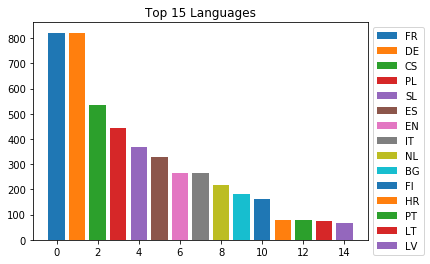

In [7]:
languages = pd.value_counts(df.LG)
for i, lang in enumerate(languages.index[:15]):
    plt.bar(i, languages[lang], label=lang)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Languages")
plt.show()

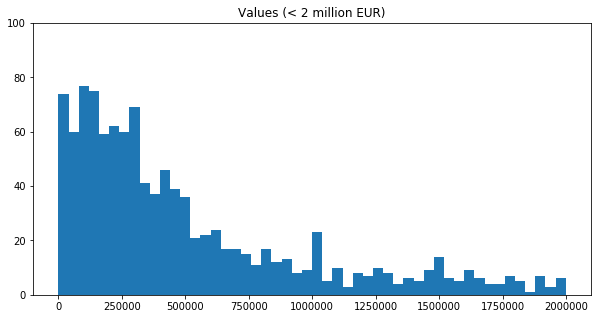

In [50]:
values = df['VALUE_EUR'].astype("float")
plt.figure(figsize=(10,5))
plt.hist(values[values < 2000000] , bins=50)
plt.title("Values (< 2 million EUR)")
plt.ylim(0, 100)
plt.show()

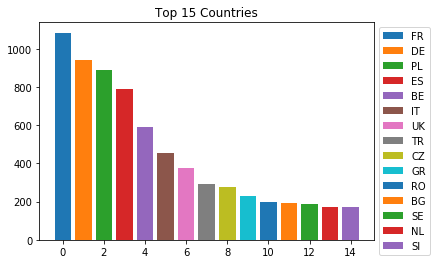

In [57]:
countries = pd.value_counts(df['ISO_COUNTRY_VALUE'])
for i, country in enumerate(countries.index[:15]):
    plt.bar(i, countries[country], label=country)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Countries")
plt.show()

### Vectorize Text

In [71]:
# get text takes in a dataframe and a language, it will extract the short_description fields for
# the specified language from the dataframe and return those along with the stop words for
# that language.
def get_text(df, lang):
    lang = lang.upper()
    def get_stop_words(lang="EN"):
        lang = lang.lower()
        file_name = "stopwords-" + lang + ".txt"
        if not os.path.exists(file_name):
            print("File", file_name,  "doesn't exist, trying to download")

            # try to download the file
            try:
                wget.download("https://raw.githubusercontent.com/stopwords-iso/stopwords-"+lang+"/master/"+file_name)
                stop_words_df = pd.read_csv(file_name, header=None)
            except:
                print("Error downloading!")
                return []
        else:
            stop_words_df = pd.read_csv(file_name, header=None)

        stop_words = list(stop_words_df[0].values)
        return stop_words
    
    description = df.loc[df["LG"] == lang, 'short_desc_str']
    stop_words = get_stop_words(lang)
    
    return description, stop_words

In [77]:
short_desc, stop_words = get_text(df, "FR")

In [78]:
# Fit our TF-IDF vectorizer
tfv = TfidfVectorizer(min_df=20,  max_features=None,
        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words=stop_words,
        )

tfv.fit(short_desc)
tfidf_feats = tfv.transform(short_desc)

In [79]:
tfv.get_feature_names()

['000',
 '000 eur',
 '000 eur ht',
 '1',
 '1 1',
 '1 1 2019',
 '1 2019',
 '1 an',
 '12',
 '2',
 '2015',
 '2015 899',
 '2016',
 '2016 360',
 '2016 360 25',
 '2016 relatif',
 '2016 relatif marches',
 '2019',
 '25',
 '25 3',
 '25 3 2016',
 '3',
 '3 2016',
 '3 2016 relatif',
 '31',
 '31 12',
 '360',
 '360 25',
 '360 25 3',
 '4',
 '5',
 '6',
 '66',
 '67',
 '67 68',
 '68',
 '68 decret',
 '7',
 '78',
 '78 80',
 '78 80 decret',
 '80',
 '80 decret',
 '80 decret no',
 '899',
 'accord',
 'accord cadre',
 'accord cadre bons',
 'accord cadre conclu',
 'accords',
 'accords cadres',
 'acquisition',
 'agit',
 'agit accord',
 'agit accord cadre',
 'an',
 'annuel',
 'ans',
 'appel',
 'appel offres',
 'application',
 'application articles',
 'article',
 'articles',
 'articles 25',
 'articles 78',
 'articles 78 80',
 'assistance',
 'assurance',
 'attributaire',
 'attribution',
 'attribution marche',
 'batiments',
 'besoins',
 'bons',
 'bons commande',
 'bons commande minimum',
 'cadre',
 'cadre bons',
 'c

In [80]:
tfidf_feats.shape

(822, 217)